# Flores Usage Analysis

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

**3 May 2022**

[TASK](https://phabricator.wikimedia.org/T299769) | [CODEBASE](https://github.com/wikimedia-research/machine-translation-service-analysis-2022)


A new machine translation engine service, Flores, was deployed starting on 1 February 2022 in [T298584](https://phabricator.wikimedia.org/T298584). This service can currently be used to translate from English to Chinese, Icelandic, Hausa, Zulu, Igbo, Occitan, and Luganda. We want to understand its usage and impact on translations (in terms of quantity and quality).

Some aspects we may want to measure:

* How often Flores used in the different languages where it is available (maybe compared with other services available on those languages)?
* How many translations are created using Flores (also as percentage of the total for the language) by publication status (draft or published)?
* Which is the deletion rate for the articles created using Flores?
* How much is the initial translation modified by users when using Flores?

[Languages currently supported by Flores](https://phabricator.wikimedia.org/diffusion/GCXS/browse/master/config/Flores.yaml?useskin=vector-2022)


# Data Sources:

Data comes from the following sources:
* [cx_corpora table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_corpora_table?useskin=vector-2022)
* [cx_translations table](https://www.mediawiki.org/wiki/Extension:ContentTranslation/cx_translations_table?useskin=vector-2022)
* [mediawiki_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/MediaWiki_history): 2022-03 snapshot

We reviewed data from 2 February 2022 (when Flores was first deployed) through 29 April 2022, with the exception of deletion rate data which relies on data from mediawiki_histroy that only included data through 31 March 2022.

Notes:
  * The corpus table captures up to three rows per section
    * The original untranslated source section content(cxc_origin is "source"). This get saved to database when placeholder is clicked in CX. In SX, this will get saved later - when publishing happens. Because there is no "auto save " in SX.
    * The unmodified machine translation (cxc_origin is "Google", "Apertium" etc). This get saved as part of auto save, when MT is arrived to user
    * The final edited translation by user.(cxc_origin is "user"). This get saved as part of auto save in CX. In SX this happens when publishing.
    

In [143]:
# load required R packages
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales); library(gt)
})

In [144]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [178]:
cbPalette <- c("#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

In [145]:
mt_data <-
  read.csv(
    file = 'Data/mt_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all cx data

In [146]:
#convert date back to integer

mt_data$translation_start_time <- format(mt_data$translation_start_time, scientific=F)

In [ ]:
# convert time sent to date time
mt_data$translation_start_time <- as.Date(mt_data$translation_start_time, format = "%Y%m%d%H%M%S")

In [274]:
# restrict to usage of flores in different langauges where available
flores_usage_compare <- mt_data %>%
#limit to only languages where available
    filter(source_language == 'en',
          target_language %in% c('ig','is', 'lg', 'oc', 'zh', 'zu'),
          translation_type == 'mt_engine', #remove source and user translations
          translation_start_time >= '2022-02-01')  #only translations started after deployment date


In [275]:

# Rename wikis and set factor levels
flores_usage_compare$target_language <- factor(flores_usage_compare$target_language, 
                                               levels = c('ig','is', 'lg', 'oc', 'zh', 'zu'),
                                              labels = c('Igbo', 'Icelandic' , 'Luganda', 'Occitan', 'Chinese', 'Zulu'))

flores_usage_compare$mt_service = factor(flores_usage_compare$mt_service,
                                    levels = c('scratch','LingoCloud', 'Yandex', 'Google', 'Flores')
             )

# How often Flores used in the different languages where it is available (compared with other services available on those languages)?


In [290]:
flores_usage_compare_mt <- flores_usage_compare %>%
   group_by(target_language, mt_service, translation_status) %>%
    summarise(num_mt_translations = n_distinct(translation_id),
             .groups = 'drop')

In [298]:
# find percent of all published languages
flores_usage_bymt_pct <- flores_usage_compare_mt %>%          
    group_by(target_language, translation_status) %>%
    mutate(num_translations = sum(num_mt_translations)) %>%  #count total for each language and status
    group_by(target_language, mt_service, translation_status) %>% #now find mt service prop
    summarise(num_mt_translations =  num_mt_translations,
        pct_translations = num_mt_translations/num_translations, .groups = 'drop')


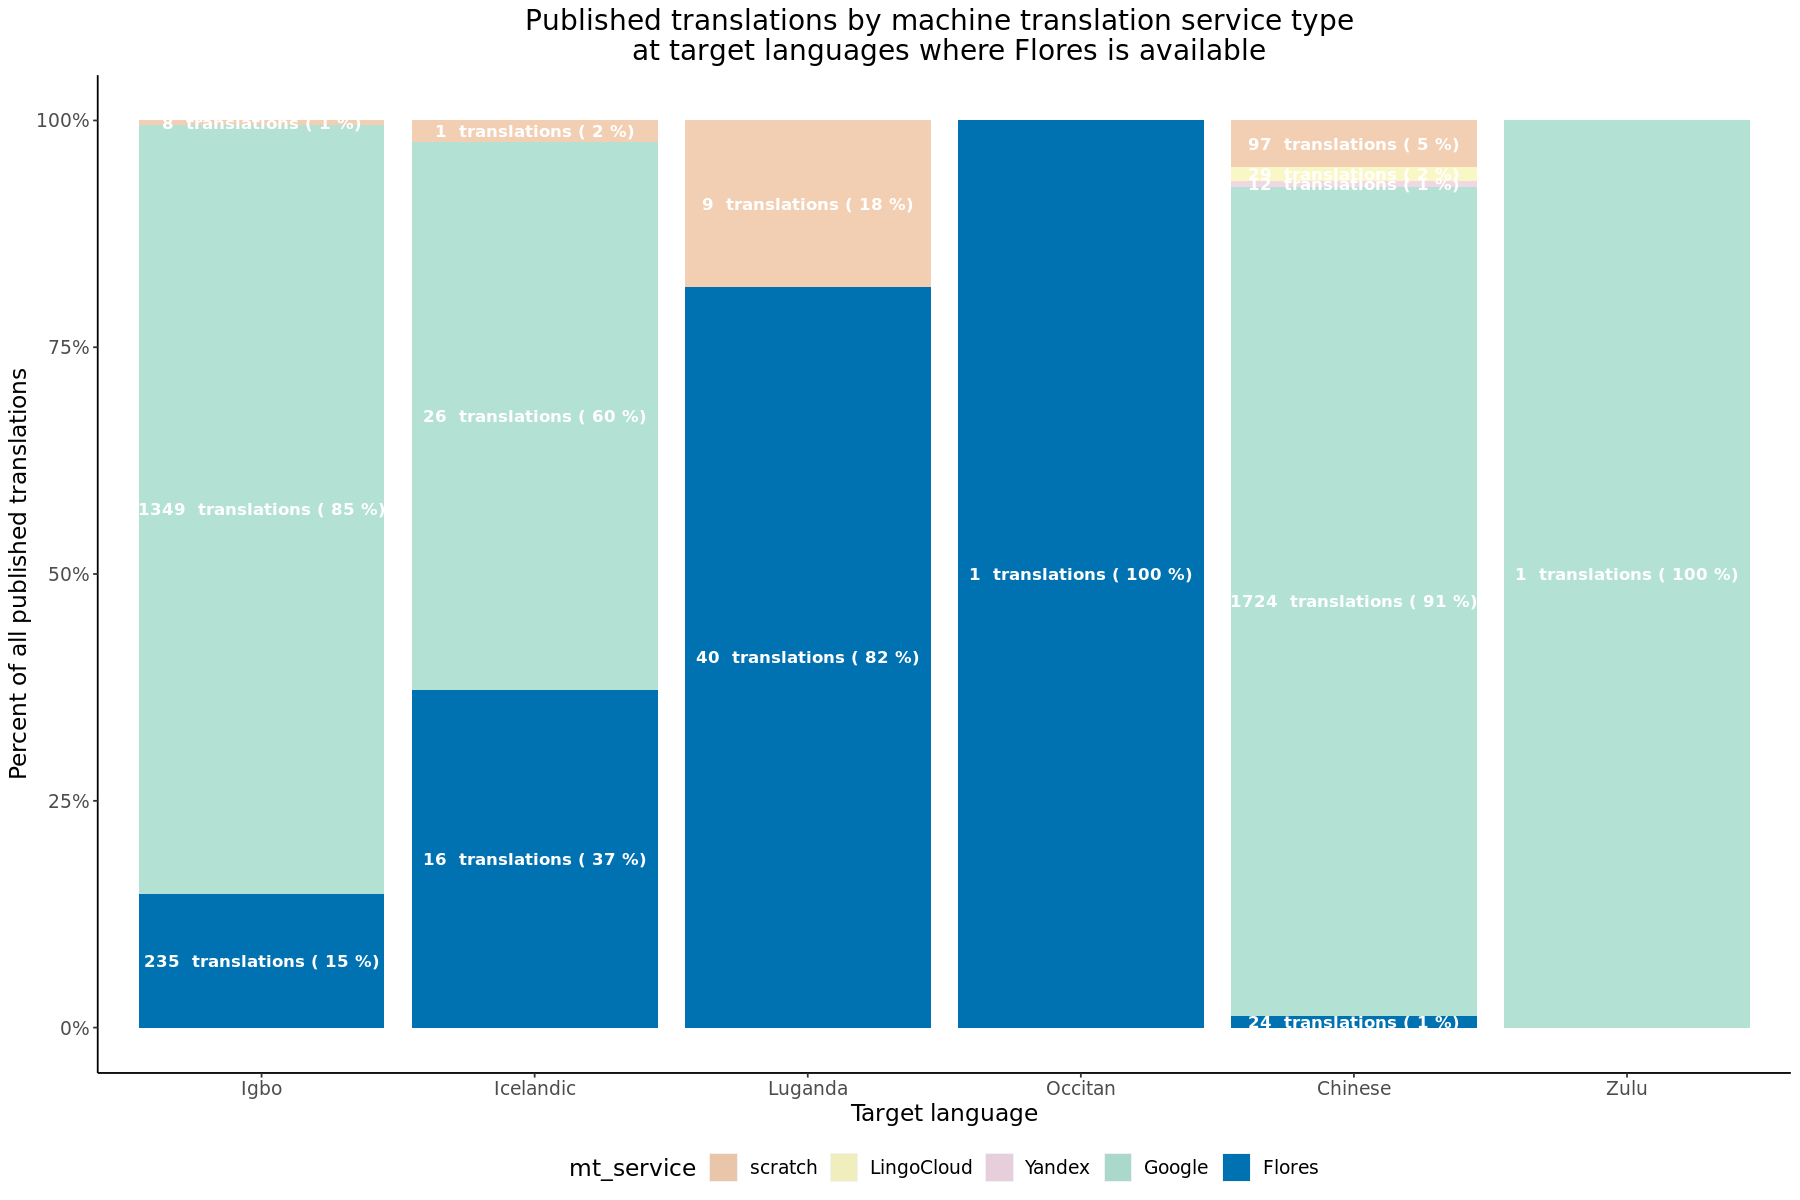

In [350]:
# Chart usage compared to other services
p <- flores_usage_bymt_pct  %>%
        filter(translation_status == 'published') %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                 label = paste(num_mt_translations, " translations", "(", round(pct_translations * 100,0), "%)")))+
        geom_bar(aes(alpha = mt_service == 'Flores'), stat = 'identity') +
        scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.3), guide = F) +
        #coord_flip() +
        geom_text(size = 3.5, fontface = "bold", color = 'white', position = position_stack(vjust = 0.5)) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all published translations",
             title = "Published translations by machine translation service type \n at target languages where Flores is available"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.3, 0.3, 0.3,0.3, 1)))) +
         scale_fill_manual(values = c("#D55E00", "#F0E442", "#CC79A7", "#009E73", "#0072B2")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/flores_usage_compare_pct_pub.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

* Flores has not been used for any published translations for Zulu and only 1% of published translations for the Chinese target language. Google is still the primary machine translation service used at these target languages.
* Flores has been used more for the Icelandic target language. Since deployment, Flores was used to translate 37% of published translations for the Icelandic target language.
* Flores is used for 100% of published translations at Occitan and the majority of translations (82%) at Luganda (18% of translations were identifed as having no mt service being used (`cxc_origin = 'scratch'`), which is expected as it was enabled by default for these langauges.


The chart above reflects published translations but some Flores translations may still be in progress. We next reviewed the percent of draft translations made using Flores for comparison.

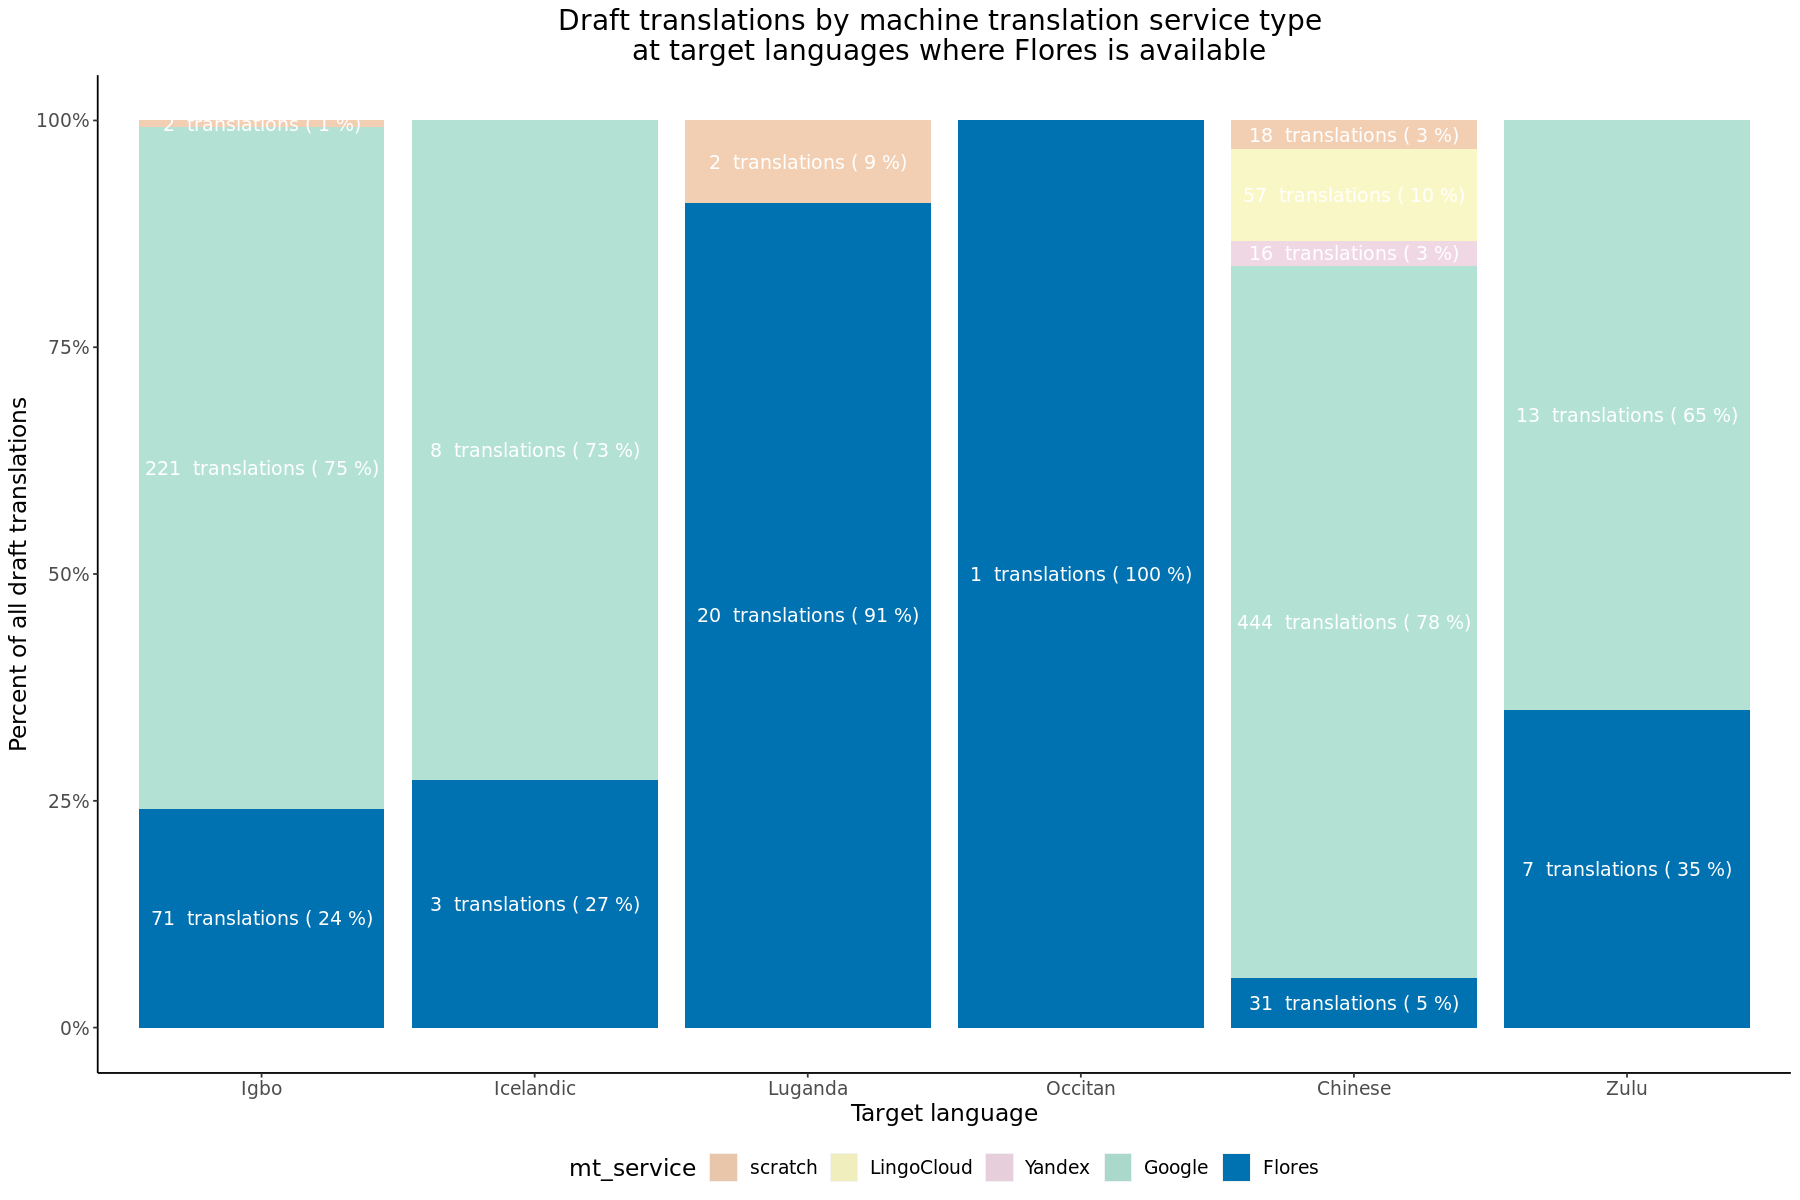

In [352]:
# Chart draft publication status
p <- flores_usage_bymt_pct %>%
        filter(translation_status == 'draft') %>% 
        ggplot(aes(x = target_language, y= pct_translations, fill = mt_service, 
                label = paste(num_mt_translations, " translations", "(", round(pct_translations * 100,0), "%)")) )+
        geom_bar(aes(alpha = mt_service == 'Flores'), stat = 'identity') +
        scale_alpha_manual(values = c("TRUE" = 1, "FALSE" = 0.3), guide = F) +
        #coord_flip() +
        geom_text(size = 4, color = 'white', position = position_stack(vjust = 0.5)) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target language",
              y = "Percent of all draft translations",
             title = "Draft translations by machine translation service type \n at target languages where Flores is available"
             ) +
         guides(fill = guide_legend(override.aes= list(alpha = c(0.3, 0.3, 0.3,0.3, 1)))) +
         scale_fill_manual(values = c("#D55E00", "#F0E442", "#CC79A7", "#009E73", "#0072B2")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
            

ggsave("Figures/flores_usage_compare_pct_draft.png", p, width = 16, height = 8, units = "in", dpi = 300)
  p
    

* When looking at draft (in-progress ) translations, we see a higher percentage of Flores usage for all the target languages except for Icelandic which has a higher percentage of published translations (37%) made with Flores than draft translations (27%).
* Zulu did not have any published translations created with Flores but 35% of it's draft publications have used Flores.



# How many translations are created using Flores (also as percentage of the total for the language) by publication status (draft or published)?

## Time series chart of Flores usage 

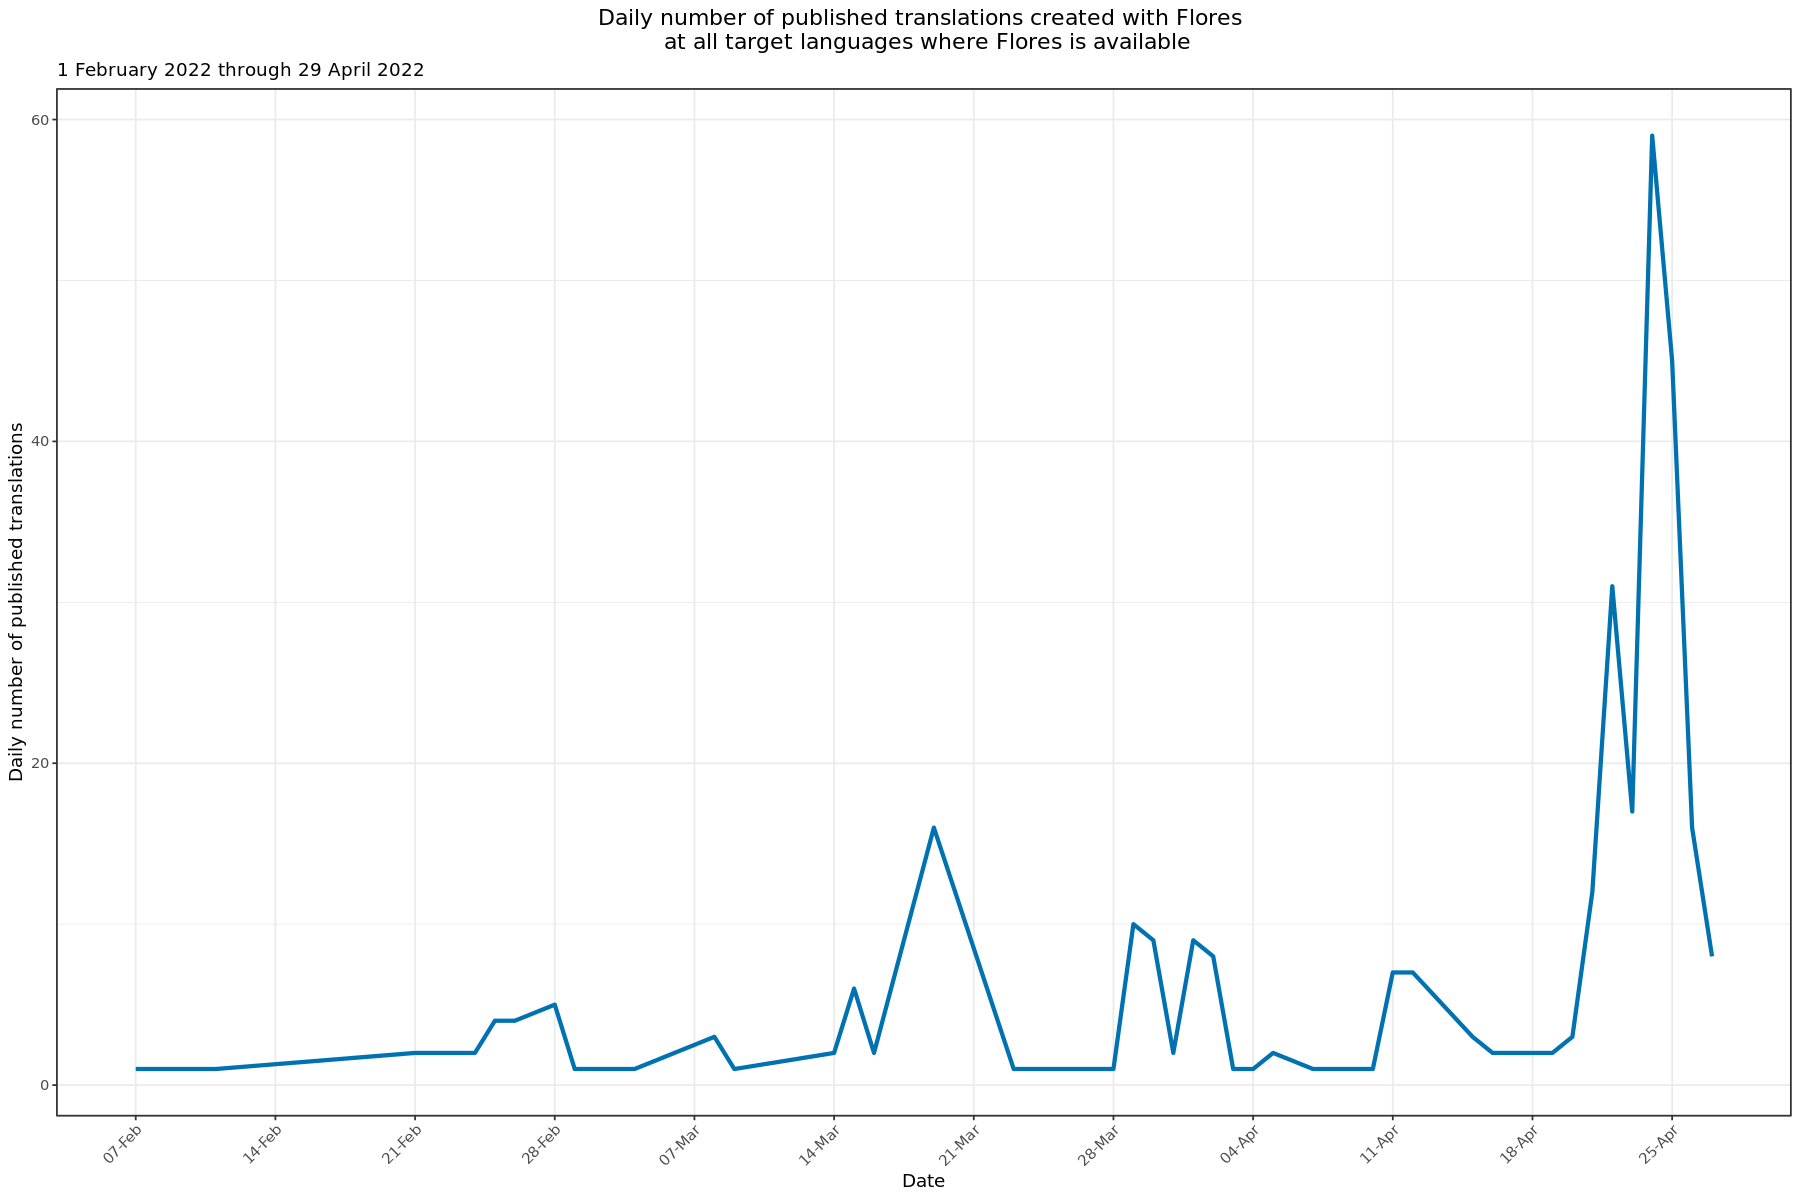

In [329]:
p <- flores_usage_compare %>%
#limit to only languages where available
    filter(mt_service == 'Flores', #rnly Flores publications
          translation_status == 'published')  %>%  #only translations started after deployment date
    group_by(translation_start_time) %>% 
    summarise(num_translations = n_distinct(translation_id), .groups = 'drop')  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations)) +
    geom_line(size = 1.2, color = "#0072B2") +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily number of published translations created with Flores \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 29 April 2022")  +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

ggsave("Figures/flores_usage_byday.png", p, width = 16, height = 8, units = "in", dpi = 300)

p

Since deployment of the service, there has been a gradual increase in the average daily number of translations that used Flores at all target languages where available.  On 22 April 2022, the number of translations increased from 17 to 32 translations a day with peak of 59 published translations on 24 April 2022. 

Note: There was a spike in translations on 19 March 2022, where there were 32 translations on 1 day at Luganda Wikipedia.

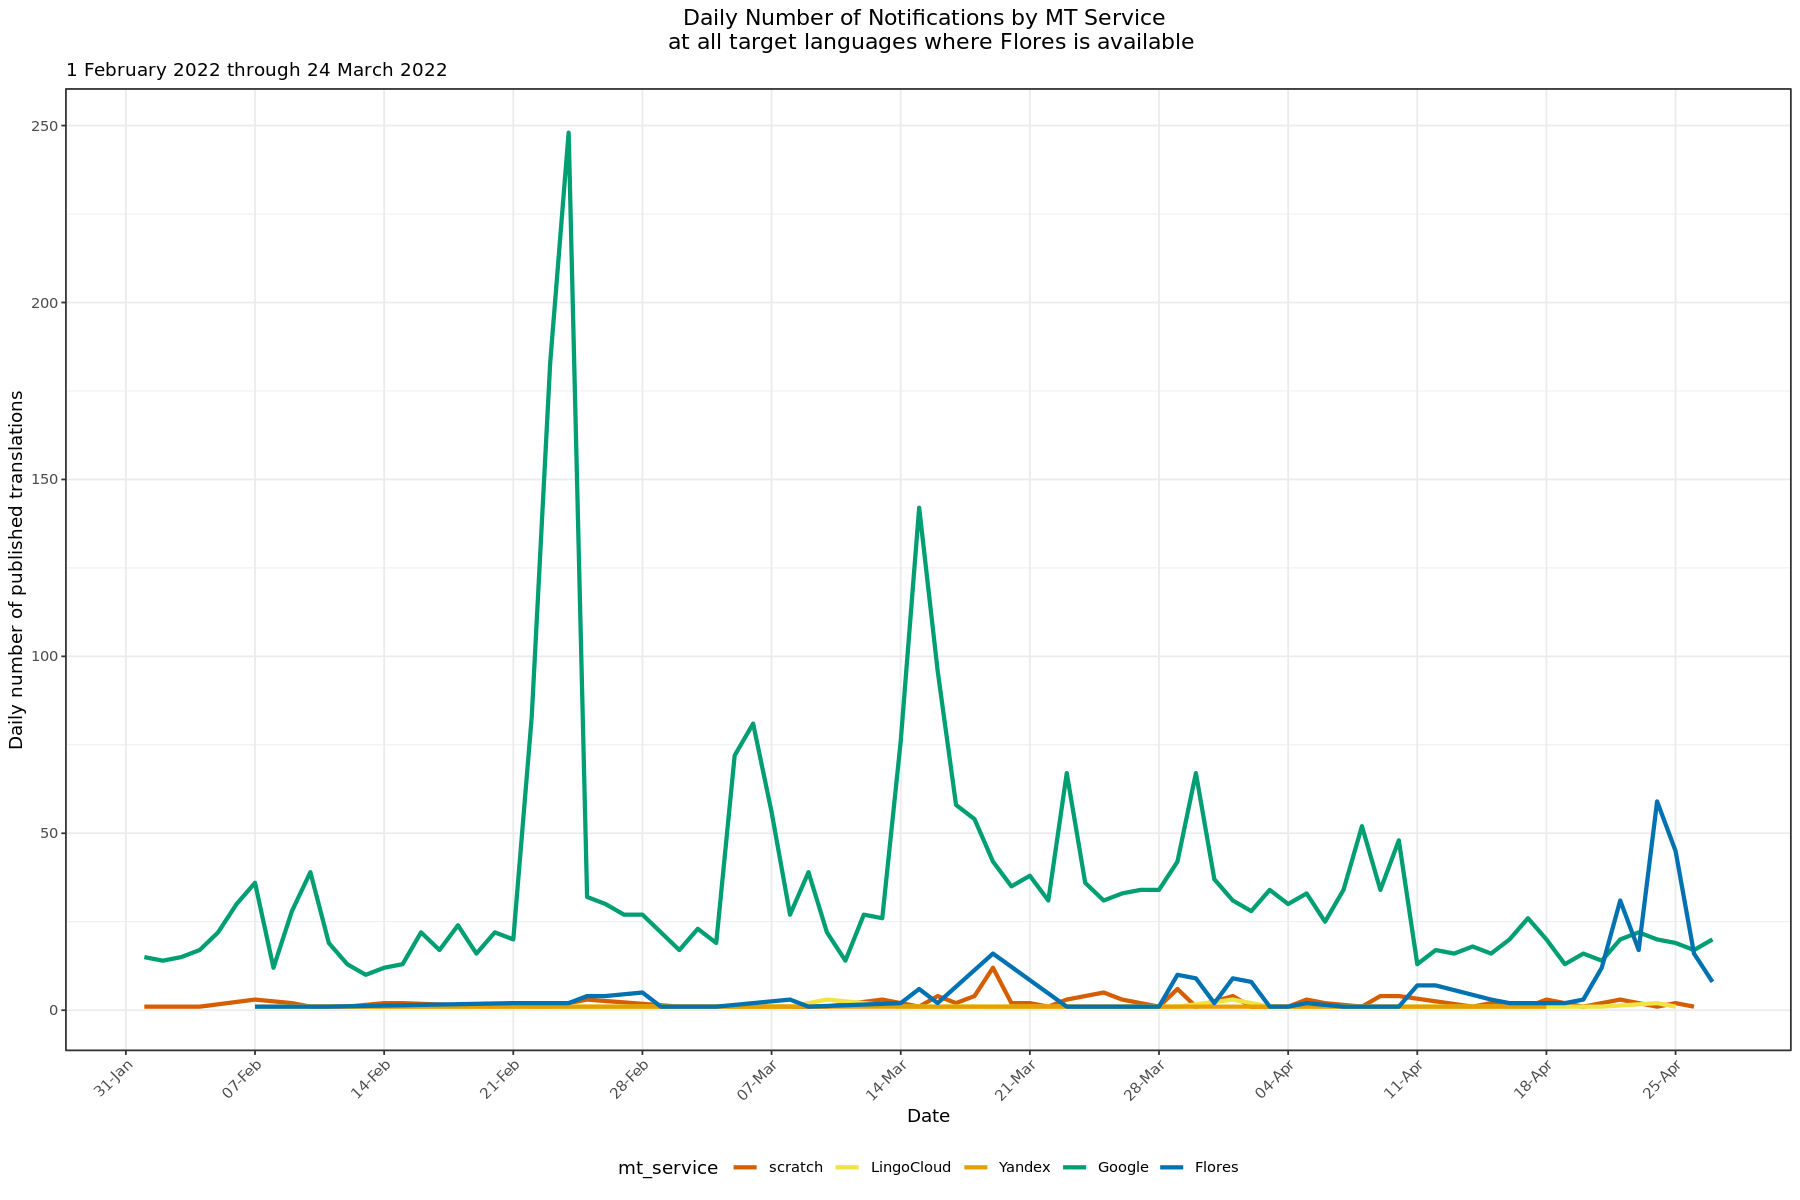

In [306]:
flores_usage_overtime_bywiki <- flores_usage_compare %>%
#limit to only languages where available
    filter(translation_status == 'published')  %>%  #only translations started after deployment date
    group_by(translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id), .groups = 'drop')  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations, color = mt_service)) +
    geom_line(size = 1.2) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily Number of Notifications by MT Service \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 24 March 2022")  +
    scale_color_manual(values = c("#D55E00", "#F0E442", "#E69F00", "#009E73", "#0072B2")) +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

flores_usage_overtime_bywiki

The daily number of published translations with Flores at all target languages surpassed Google in late April. This is likely due to the deployment of FLores as the default languages at Igbo, Icelandic, and Zulu target languages in https://phabricator.wikimedia.org/T305125.

## By Target Language

`summarise()` regrouping output by 'target_language', 'translation_start_time' (override with `.groups` argument)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



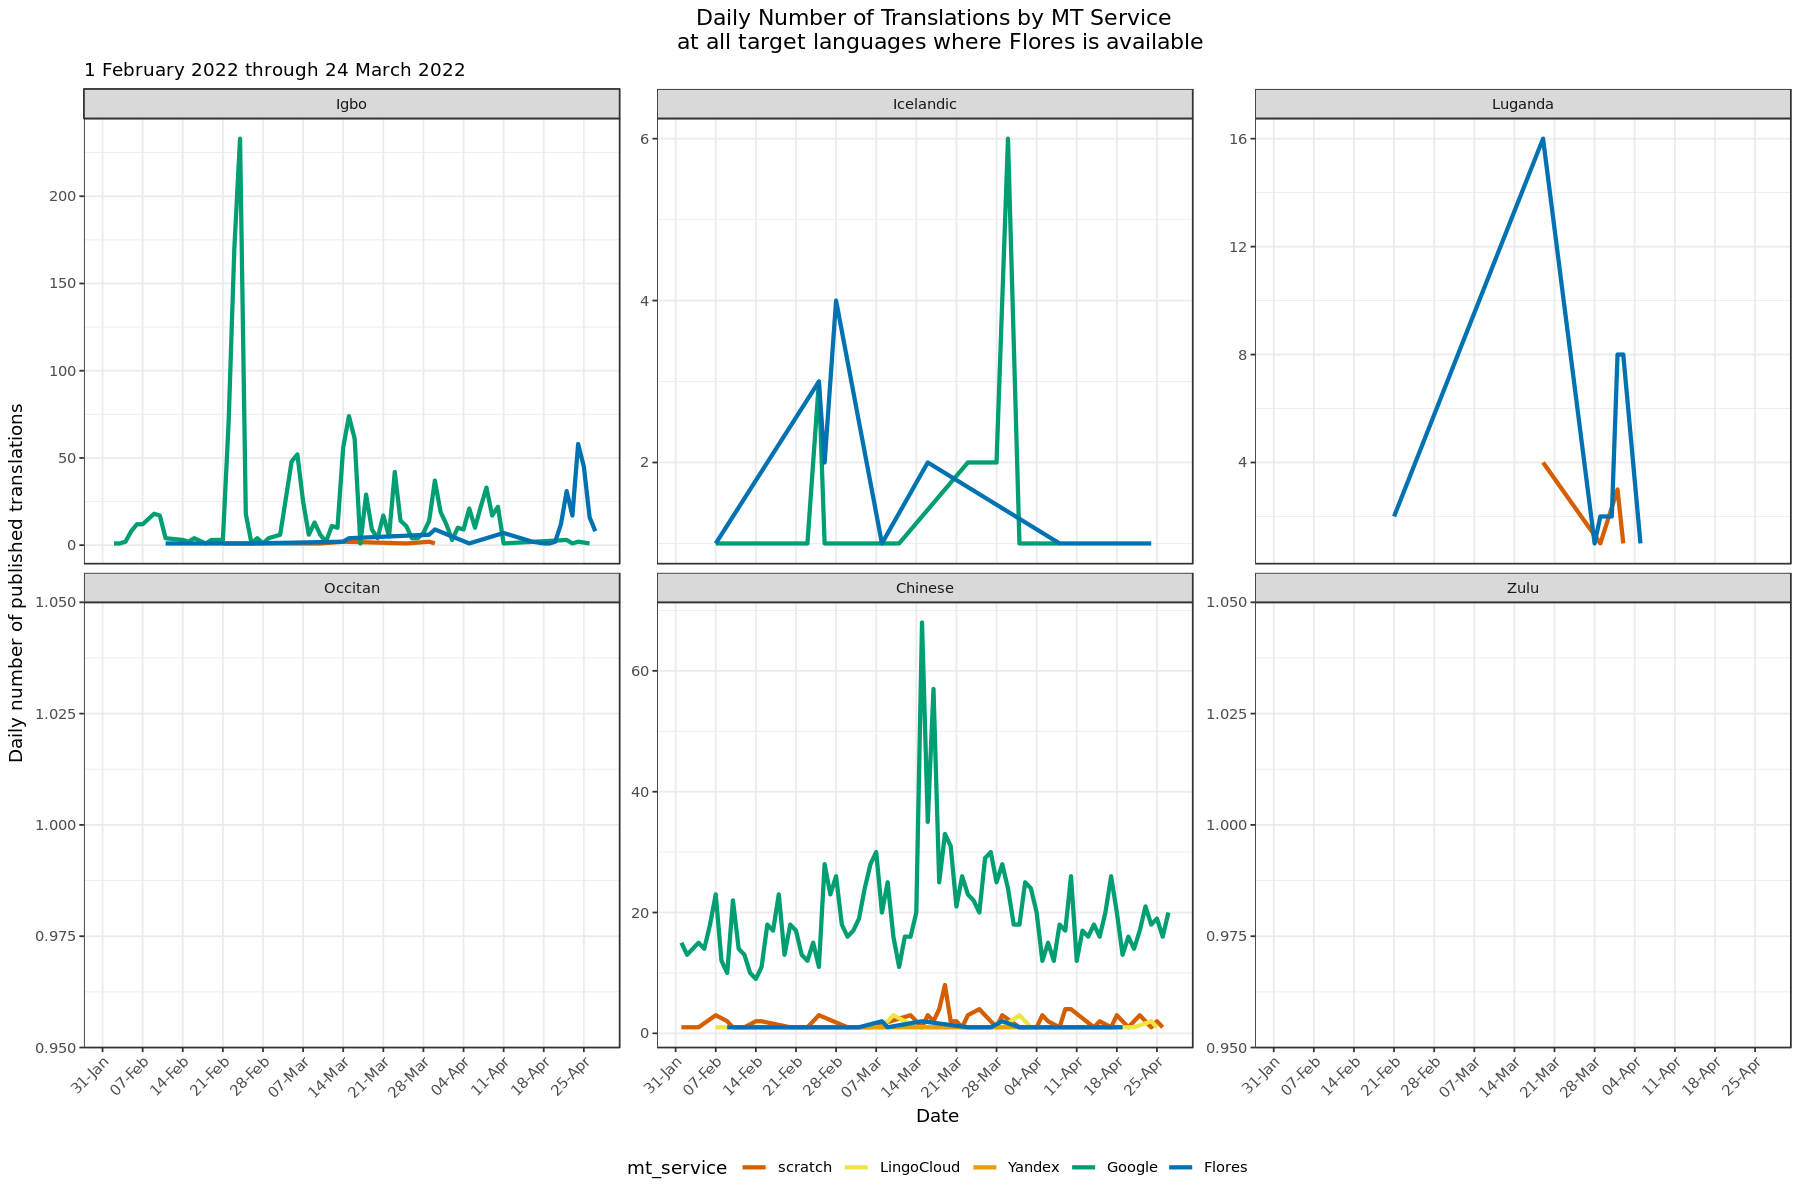

In [308]:

flores_usage_overtime_bylang <- flores_usage_compare %>%
#limit to only languages where available
    filter(translation_status == 'published')  %>%  #only published translations
    group_by(target_language, translation_start_time, mt_service) %>% 
    summarise(num_translations = n_distinct(translation_id))  %>% 
    ggplot(aes(x= translation_start_time, y = num_translations, color = mt_service)) +
    geom_line(size = 1.2) +
    facet_wrap(~target_language, scale = 'free_y') +
    scale_x_date(date_labels = "%d-%b", date_breaks = "1 week", minor_breaks = NULL) +
    labs (y = "Daily number of published translations",
          x = "Date",
         title = "Daily Number of Translations by MT Service \n at all target languages where Flores is available",
         subtitle = "1 February 2022 through 24 March 2022")  +
     scale_color_manual(values = c("#D55E00", "#F0E442", "#E69F00", "#009E73", "#0072B2")) +
     theme_bw() +
   theme(legend.position = "bottom",
        axis.text.x=element_text(angle = 45, hjust = 1),
        plot.title = element_text(hjust = 0.5)) 

flores_usage_overtime_bylang 

* The spike in published translations using Flores occured at Luganda Wikipedia on 19 March 2022. There were no spikes in translations at the other available MT services or target languages on this day. 
* Confirmed that late April increase in Flores translations occurs at the Igbo target language. No changes in usage at published translations at Zulu or Icelandic.

# How many translations are published using Flores (also as percentage of the total for the language)?

In [310]:
# usRage of flores in different langauges where available
flores_usage_total_bywiki <- flores_usage_bymt_pct  %>%
    filter(mt_service == 'Flores') %>%
    mutate(pct_translations = paste(round(pct_translations * 100, 2), "%"))  %>%
    pivot_wider(id_cols = target_language, names_from = translation_status, values_from= (c(num_mt_translations, pct_translations)))


In [326]:
flores_usage_bywiki_tbl <- flores_usage_total_bywiki %>%
  gt() %>%
  tab_header(
    title = "Percent of translations created with Flores \n at each target language",
      subtitle = "1 Feb 2022 through 29 April 2022"
  )  %>%
  cols_label(
    num_mt_translations_draft = "Number",
    num_mt_translations_published = "Number",
    pct_translations_draft = "Percent",
    pct_translations_published = "Percent"
  ) %>%
    tab_spanner(
      label = "Draft Translations",
      columns = c("num_mt_translations_draft", "pct_translations_draft")
    )%>%
    tab_spanner(
      label = "Published Translations",
      columns = c("num_mt_translations_published", "pct_translations_published")
    )  %>%
    gtsave(
    "flores_usage_bywiki_tbl.html", inline_css = TRUE)

IRdisplay::display_html(data = flores_usage_bywiki_tbl, file = "flores_usage_bywiki_tbl.html")

flores_usage_bywiki_tbl

Draft Translations,Published Translations


NULL

# Which is the deletion rate for the articles created using Flores? 

We next reviewed the the percent of articles created with Flores that have been deleted.

Method: I used target_revision_id of all published translations logged in the cx_translations table and joined to mediawiki_history to determine deletion status. Note: This reflects the deletion status as of the '2022-03' mediawiki snapshot. 

Caveats:
* It's possible that a higher percent of these articles will be deleted following their review. This analysis can be rerun at a later date to see if more articles have been deleted following a longer review period.
* Articles published after March 2022 are not reflected in this data as only the '2022-03' mediawiki snapshot was available at the time of this analysis.

In [222]:
flores_deletion_data <-
  read.csv(
    file = 'Data/flores_deletion_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all flores deletion data

In [223]:
head(flores_deletion_data)

,wiki,created_cx_total,deleted_cx_total
,<chr>,<int>,<lgl>
1,zhwiki,12,NA
2,lgwiki,29,NA
3,igwiki,19,NA
4,iswiki,13,NA


Since Flores was deployed until the end of March 2022 [^timeline], a total of 73 translations were created using Flores across all target languages where available. None of these translation were deleted during this timeframe.


[^timeline]: Analysis limited to data available in the '2022-03' mediawiki_history snapshot at the time of this analysis. As a result, translations created or delted after this data have not been reflected. I'd recommend reassesing the deletion ratio at a later date to include more publications and a longer article review period. 


# How much is the initial translation modified by users when using Flores?

For the purpose of this analysis, I limited the analysis to only published translations and reviewed the percent the intial translation was modified by users into three catergories: less than 10%, between 11 and 50%, and over 50%. These categories can be adjusted as needed. 

Method: Data on percent each translation is modified comes from the `translations_progress` field [^Note] in the cx_translation table (as indicated by the `human` percentage stat). 

[^Note]: The translations_progress data shows the percentage of translation completion. human indicates manual translation percentage. mt indicates machine translation percentage. Any edits to machine translation output are considered as manual edits. The percentages are calculated at section level. any indicates the total translation (any=human+mt). Content Translation does not demand full translation of the source article.

In [320]:
# Flores modifications by percent modified

flores_modification <- flores_usage_compare %>%
   filter(mt_service == 'Flores', 
           translation_status == 'published')  %>%
    mutate(pct_human_modified = case_when(
        human_translated_percent < 0.10  ~ "less than 10%",
         (human_translated_percent >= 0.10 &  human_translated_percent < 0.51) ~ "between 11 and 50%",
         human_translated_percent >= 0.51  ~  "over 50%"),
          pct_human_modified = factor(pct_human_modified, 
                                        levels=c("less than 10%","between 11 and 50%","over 50%")))
    

### Overall 

In [354]:
# find percent mt modified by languages where Flores is available
flores_modification_overall <- flores_modification %>%
    mutate(pct_human_modified = factor(pct_human_modified,
                                    levels = c('over 50%', 'between 11 and 50%', 'less than 10%'))) %>%
    group_by(pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id), .groups = 'drop') %>%
    ungroup() %>%
    summarise(pct_human_modified,
            num_translations,
              pct_translations = paste0(round(num_translations/sum(num_translations) * 100,2), "%"), .groups = 'drop') 
    
flores_modification_overall

pct_human_modified,num_translations,pct_translations
<fct>,<int>,<chr>
over 50%,17,5.38%
between 11 and 50%,72,22.78%
less than 10%,227,71.84%


The majorty of translations (71.8%) published using Flores were modified less than 10% by users at all target languages where available. Only about 5.4% of Flores translations were modified over 50%. 

Note: This looks acrss all target languages though. A review by target langauge will identify if these trends differ per wiki.

## By Target Language

In [322]:
# find percent mt modified by languages where Flores is available
flores_modification_bytarget <- flores_modification %>%
    group_by(target_language, pct_human_modified) %>%
    summarise(num_translations = n_distinct(translation_id), .groups = 'drop')  %>%
    group_by(target_language) %>%
    summarise(pct_human_modified,
            num_translations,
              pct_translations = num_translations/sum(num_translations), .groups = 'drop')
    

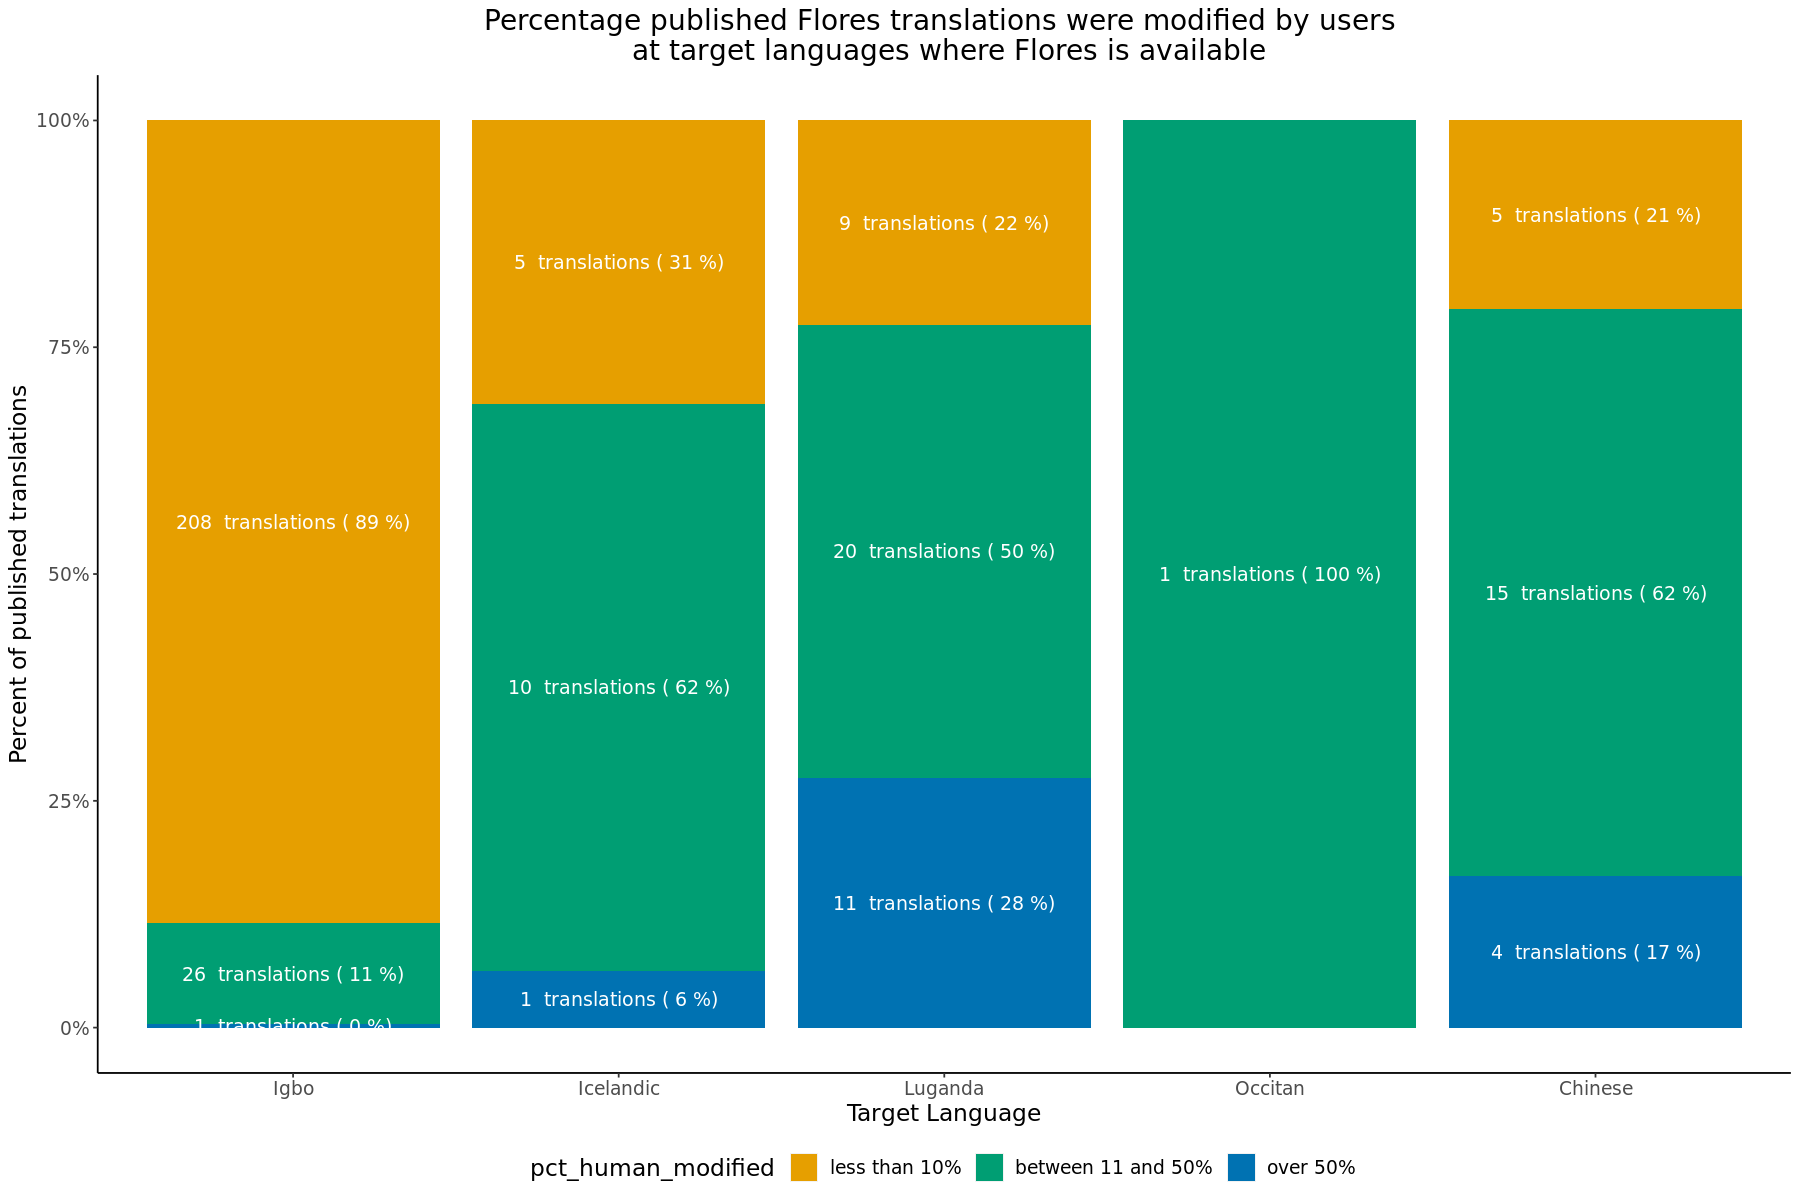

In [328]:

# Chart usage compared to other services
p <- flores_modification_bytarget %>%
        ggplot(aes(x = target_language, y= pct_translations, fill = pct_human_modified,
                  label = paste(num_translations, " translations", "(", round(pct_translations * 100,0), "%)")) ) +
        geom_bar(stat = 'identity') +
         geom_text(size = 4, color = 'white', position = position_stack(vjust = 0.5)) +
        scale_y_continuous(labels = scales::percent) +
        labs (x = "Target Language",
              y = "Percent of published translations",
             title = "Percentage published Flores translations were modified by users \n at target languages where Flores is available"
             ) +
         scale_fill_manual(values = c("#E69F00", "#009E73", "#0072B2")) +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

        
        ggsave("Figures/flores_modification_bytarget.png", p, width = 16, height = 8, units = "in", dpi = 300) 
        p
            

A breakdown by target languages shows that Igbo Wikipedia is actually the only target language where the majority of published translations are modified less than 10% (89% of published Igbo translations). For the other target languages, the majority of translation are modified between 11 and 50%.  